# Markovic

This notebook shows how to construct an efficient frontier of stocks based on mean variance optimization. 

### Variables

$$
\begin{equation}
C : \textrm{number of stocks}\\
T : \textrm{number of time observations} \\
\boldsymbol{\mu} : \textrm{mean stock return (C x 1)} \\
\boldsymbol{\Sigma} : \textrm{covariance matrix of returns (C x C)} \\
\mu_{targ} : \textrm{target mean return}
\end{equation}
$$

### Global Minimum Variance Portfolio

The weights, mean, and variance of the global minimum variance portfolio are
$$
\begin{equation}
\boldsymbol{w}_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota 
= \frac{\Sigma^{-1} \iota }{C}\\
\mu_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota}\mu' \Sigma^{-1} \iota 
= \frac{B}{C}\\
\sigma_{gmv}^2 = \frac{1}{\iota' \Sigma^{-1} \iota}
= \frac{1}{C}
\end{equation}
$$


### Efficient Frontier

The efficient frontier is defined as a linear combination of two portfolios. 
$$
\begin{equation}
\boldsymbol{w} = \lambda \boldsymbol{w}_{mu} + (1-\lambda) \boldsymbol{w}_{gmv} \\
\lambda = \frac{BC\mu_{targ}-B^2}{AC-B^2} \\
\textrm{where}\\
A = \mu' \Sigma^{-1} \mu\\
B = \mu' \Sigma^{-1} \iota\\
C = \iota' \Sigma^{-1} \iota\\
\end{equation} 
$$


In [1]:
from pathlib import Path
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
def preprocess_column_name(column_name):
    column_name = column_name.title().replace(' ','').strip()
    return column_name


## Data Extraction 

### 1. Tickers



In [3]:
rawTickerDataPath = Path('data') / 'nasdaq_screener_1612565816157.csv'
processedTickerDataPath = Path('data') / 'tickers.csv'
selectedColumns = ['Symbol', 'Name', 'MarketCap', 'Country', 'Sector', 'Industry']

if not processedTickerDataPath.exists():
    print('- load raw ticker data')
    tickersDF = pd.read_csv(rawTickerDataPath)
    print('- process raw ticker data')
    tickersDF.columns = [preprocess_column_name(e) for e in tickersDF.columns]
    tickersDF = tickersDF[selectedColumns]
    print('- save processed ticker table')
    # tickersDF.to_csv(processedTickerDataPath, index=False)
else:
    print('load processed ticker table')
    tickersDF = pd.read_csv(processedTickerDataPath)


- load raw ticker data
- process raw ticker data
- save processed ticker table


### 2. Prices

In [5]:
pricesDataPath = Path('data') / 'prices.csv'
numCompanies = 5

if not pricesDataPath.exists():
    print('get returns from yahoo')
    tickers = tickersDF['Symbol'].tolist()
    tickers = [e for e in tickers if '^' not in e or '/' not in e]
    pricesDF = yf.download( 
    tickers = ' '.join(tickers[:numCompanies]),
    period = "5y",
    interval = "1d",
    group_by = 'ticker',
    # auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
    )
    # pricesDF.to_csv(pricesDataPath, index=False)
else:
    print('load downloaded returns table')
    pricesDF = pd.read_csv(pricesDataPath, header =[0,1])

pricesDF.head(2)


get returns from yahoo
[*********************100%***********************]  5 of 5 completed


ACY                                              ACU             \
             Open   High    Low  Close Adj Close Volume       Open       High   
Date                                                                            
2016-04-25  10.85  10.85  10.85  10.85     10.85    500  17.350000  17.820000   
2016-04-26  11.18  11.18  11.18  11.18     11.18    100  17.139999  17.200001   

                                  ...   AAMC                          \
                  Low      Close  ...    Low  Close Adj Close Volume   
Date                              ...                                  
2016-04-25  16.719999  16.950001  ...  15.06  15.53     15.53  23500   
2016-04-26  16.700001  17.010000  ...  14.76  15.24     15.24  26700   

                   AE                                                     
                 Open       High        Low      Close  Adj Close Volume  
Date                                                                      
2016-04-25  38.369999  40.000000  37.200001  37.200001  32.563530   2400  
2016-04-26  38.189999  38.630001  36.990002  38.630001  33.815289   5000  

[2 rows x 30 columns]

## Data Analysis

### 1. Tickers : Industry Analysis

In [6]:
print(f"""
Number of unique Sectors : {tickersDF.Sector.unique().size}
Number of unique Industries : {tickersDF.Industry.unique().size}
""")


Number of unique Sectors : 13
Number of unique Industries : 62



### 2. Prices

In [7]:
pricesDF.columns = pd.MultiIndex.from_tuples(pricesDF.columns.swaplevel())
pricesDF = pricesDF['Adj Close']
pricesDF = pricesDF.T[pricesDF.isnull().sum().eq(0)].T
pricesDF.head(2)

,ACY,ACU,AAU,AAMC,AE
Date,,,,,
2016-04-25,10.85,15.293143,1.10,15.53,32.563530
2016-04-26,11.18,15.347281,1.15,15.24,33.815289


In [8]:
print(f"""
number of time steps: {pricesDF.shape[0]}
number of companies: {pricesDF.shape[1]}
number of companies with full history: {pricesDF.isnull().sum().eq(0).sum()}
number of companies with no history: {pricesDF.notnull().sum().eq(0).sum()}
""")



number of time steps: 1259
number of companies: 5
number of companies with full history: 5
number of companies with no history: 0



## Get stock prices and Returns

In [9]:
returnsDF = pricesDF.pct_change().iloc[1:]
logReturnsDF = np.log(1+returnsDF)

p = pricesDF.to_numpy() # prices
r = returnsDF.to_numpy() # returns
r_log = np.log(1+r) # log returns

T, C = p.shape # time periods, number of companies

u = r_log.mean(0)
Sigma = np.cov(r_log.T)
iota = np.ones((C,1))


### Realised returns

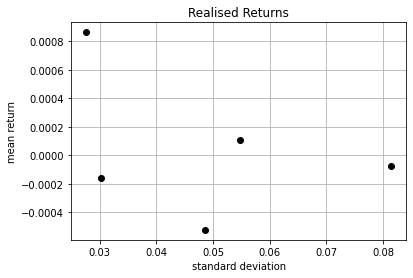

In [10]:
vol = np.sqrt(Sigma.diagonal())
x = vol
y = u

plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.title('Realised Returns')
plt.grid()
plt.show()


### Efficient Frontier

Creating the efficient frontier plot

In [11]:
A = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), u)
B = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), iota)
C = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), iota)
D = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), u)

w_gmv = 1 / C * np.matmul(np.linalg.inv(Sigma), iota).reshape(-1,1)
u_gmv = B / C
std_gmv = np.sqrt(1 / C)

w_mu = 1 / D * np.matmul(np.linalg.inv(Sigma), u).reshape(-1,1)


In [12]:
print(f"""
Global Minimum Variance Portfolio
mean : {u_gmv[0][0]}
std : {std_gmv[0][0]}
""")


Global Minimum Variance Portfolio
mean : 0.0002661713511316671
std : 0.019350802757590085



In [13]:
c = 1.5
x = []
y = []
for u_targ in np.linspace(1/c*min(u), c*max(u), 200).tolist():
    _lambda = (B * C * u_targ - B * B) / (A * C - B * B)
    w = _lambda * w_mu + (1-_lambda) * w_gmv
    sigma = np.sqrt(np.matmul(np.matmul(w.T, Sigma), w))[0][0]
    x.append(sigma)
    y.append(u_targ)


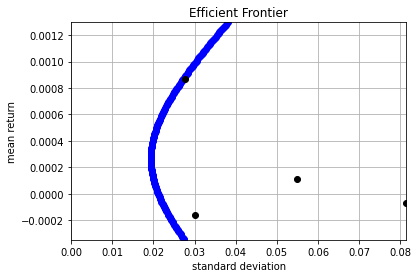

In [14]:
# plt.style.use('seaborn-whitegrid')    
vol = np.sqrt(Sigma.diagonal()).tolist()
min_sigma = min(x + vol)
max_sigma = max(x + vol)
min_return = min(y)
max_return = max(y)
plt.plot(x, y, 'o', color='blue')
x = vol
y = u
plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.xlim([0, max_sigma])
plt.ylim([min_return, max_return])
plt.title('Efficient Frontier')
plt.grid()
plt.show()


## Principal Component Analysis (PCA)

Investigate the effect of applying PCA on the covariance matrix.

### - Stocks are highly correlated

/home/bart/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.0)

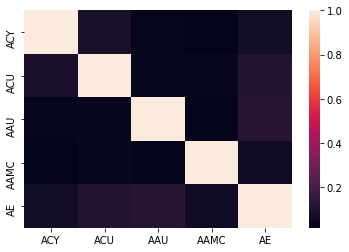

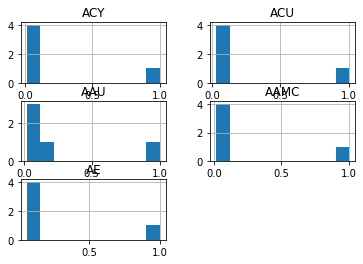

In [15]:
numStocks = 10

sns.heatmap(returnsDF[returnsDF.columns[:numStocks]].corr());
returnsDF[returnsDF.columns[:numStocks]].corr().hist();
plt.xlim([0,1])

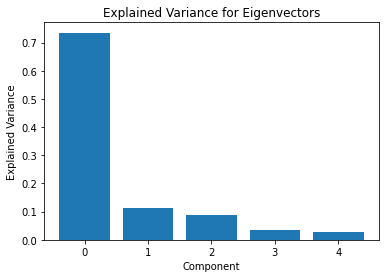

In [58]:
eigenValues, _ = np.linalg.eigh(Sigma)
eigenValues = np.flip(eigenValues)
explainedVariance = eigenValues / sum(eigenValues)
plt.bar(list(range(len(explainedVariance))), explainedVariance);
plt.title('Explained Variance for Eigenvectors');
plt.xlabel('Component');
plt.ylabel('Explained Variance');

In [52]:
def PCA(Sigma, numComponents):
    eigenValues, eigenVectors = np.linalg.eigh(Sigma)
    eigenValues = np.flip(eigenValues)
    eigenValues[numComponents:] = 0
    Q = np.flip(eigenVectors, 1)
    D = np.diag(eigenValues)
    ReducedSigma = np.matmul(np.matmul(Q, D), Q.T)
    np.fill_diagonal(ReducedSigma, np.diag(Sigma))
    return ReducedSigma

numComponents = 1
Sigma = returnsDF.cov()
ReducedSigma = pd.DataFrame(PCA(Sigma, numComponents=numComponents), columns=Sigma.columns, index=Sigma.index)
ReducedSigma, Sigma

(           ACY       ACU       AAU      AAMC        AE
 ACY   0.019842  0.000351  0.000213  0.000157  0.000295
 ACU   0.000351  0.000778  0.000004  0.000003  0.000005
 AAU   0.000213  0.000004  0.002382  0.000002  0.000003
 AAMC  0.000157  0.000003  0.000002  0.003080  0.000002
 AE    0.000295  0.000005  0.000003  0.000002  0.000929,
            ACY       ACU       AAU      AAMC        AE
 ACY   0.019842  0.000335  0.000183  0.000129  0.000277
 ACU   0.000335  0.000778  0.000046  0.000050  0.000090
 AAU   0.000183  0.000046  0.002382  0.000065  0.000184
 AAMC  0.000129  0.000050  0.000065  0.003080  0.000105
 AE    0.000277  0.000090  0.000184  0.000105  0.000929)

In [45]:
PCA(Sigma, numComponents=numComponents)

array([[1.98417579e-02, 3.50391104e-04, 2.09602751e-04, 1.25412597e-04,
        2.93605480e-04],
       [3.50391104e-04, 7.78296503e-04, 1.16893117e-05, 7.76538752e-05,
        9.50797557e-06],
       [2.09602751e-04, 1.16893117e-05, 2.38182839e-03, 3.23948481e-04,
        2.15891177e-05],
       [1.25412597e-04, 7.76538752e-05, 3.23948481e-04, 3.07991925e-03,
        1.76457883e-04],
       [2.93605480e-04, 9.50797557e-06, 2.15891177e-05, 1.76457883e-04,
        9.29349884e-04]])

In [ ]:
import numpy as np
 
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced